# Putting it all together!

In [193]:
# All the imports
import numpy as np
import pandas as pd
import pickle as pkl
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import os
from utils import *
from PIL import Image
from sys import getsizeof

# Tensorflow, sklearn, and scipy imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import *

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler

from scipy.optimize import curve_fit

sns.set(rc={'figure.figsize':(11.5,4.25)})

In [23]:
# Get AC Access Data
access_file = open('./final_datasets/AC_Access/fits.pkl', 'rb')
access_fits = pkl.load(access_file)
access_file.close()
access_mins = [0, 20000, 40000, 60000, 80000]
access_labels = ['0-19999', '20000-39999', '40000-59999', '60000-79999', '80000+']
print(access_fits)

[[ 1.65687789e-04  4.78139937e-01]
 [ 1.80235342e-03 -2.77637306e+00]
 [ 1.54988458e-03 -2.23659344e+00]
 [ 2.99404625e-03 -5.14791769e+00]
 [ 4.04530914e-03 -7.23944543e+00]]


In [67]:
# Get Household Income Data
median_income_file = open('./final_datasets/MedianIncome/HoseholdIncome.pkl', 'rb')
median_income_grid = pkl.load(median_income_file)
median_income_file.close()

median_latlon_file = open('./final_datasets/MedianIncome/LatLon.pkl', 'rb')
median_latlon = pkl.load(median_latlon_file)
median_latlon_file.close()
median_latlon = [np.array(median_latlon[0][::-1]), np.array(median_latlon[1])]
print(np.array(median_income_grid).shape)
print(len(median_latlon[0]), len(median_latlon[1]))
print(median_latlon[0][0], median_latlon[0][-1])
print(median_latlon[1][0], median_latlon[1][-1])
print(median_income_grid[1].shape)

(11, 640, 1408)
640 1408
50.22916666666667 23.60416666666667
-125.1875 -66.5625
(640, 1408)


In [37]:
# Get Population Density Data
population_density_file = open('./final_datasets/Pop_Density/PopDensityProjection.pkl', 'rb')
population_density_grid = pkl.load(population_density_file)
population_density_file.close()

population_latlon_file = open('./final_datasets/Pop_Density/LatLon.pkl', 'rb')
population_latlon = pkl.load(population_latlon_file)
population_latlon_file.close()
population_latlon = [np.array(population_latlon[0]), np.array(population_latlon[1])]
print(np.array(population_density_grid).shape)
print(len(population_latlon[0]), len(population_latlon[1]))
print(population_latlon[0][0], population_latlon[0][-1])
print(population_latlon[1][0], population_latlon[1][-1])

(3, 640, 1408)
640 1408
50.22916666666667 23.60416666666667
-125.1875 -66.5625


In [112]:
# Get Temperature Data
temp_grid_file = open('./final_datasets/Temperature/temp_YearlyAvg.pkl', 'rb')
temp_avg_grid = pkl.load(temp_grid_file)
temp_grid_file.close()

temp_grid_file = open('./final_datasets/Temperature/temp_YearlyMin.pkl', 'rb')
temp_min_grid = pkl.load(temp_grid_file)
temp_grid_file.close()

temp_grid_file = open('./final_datasets/Temperature/temp_YearlyMax.pkl', 'rb')
temp_max_grid = pkl.load(temp_grid_file)
temp_grid_file.close()

temp_latlon_file = open('./final_datasets/Temperature/LatLon.pkl', 'rb')
temp_latlon = pkl.load(temp_latlon_file)
temp_latlon_file.close()

temp_latlon = [np.array(temp_latlon[0]), np.array(temp_latlon[1])]

print(len(temp_latlon[0]), len(temp_latlon[1]))
print(temp_latlon[0][0], temp_latlon[0][-1])
print(temp_latlon[1][0], temp_latlon[1][-1])

print(temp_avg_grid.shape)
print(temp_min_grid.shape)
print(temp_max_grid.shape)

66 154
49.187534 24.812532
-124.520836 -67.145836
(10, 66, 154)
(10, 66, 154)
(10, 66, 154)


In [113]:
def match_res_grid(data, new_idx):
    new_data = []
    for t in range(len(data)):
        new_timestep = []
        for y in range(len(new_idx)):
            new_row = []
            for x in range(len(new_idx[0])):
                new_row.append(data[t][new_idx[y][x][0]][[new_idx[y][x][1]]][0])
            new_timestep.append(new_row)
        new_data.append(new_timestep)

    return np.array(new_data)

def format_grid_index(old_latlon, new_latlon):
    old_lat = old_latlon[0]
    old_lon = old_latlon[1]
    new_lat = new_latlon[0]
    new_lon = new_latlon[1]
    new_grid = []

    for y in range(len(new_lat)):
        new_row = []
        lat_idx = (np.abs(old_lat - new_lat[y])).argmin()
        for x in range(len(new_lon)):
            lon_idx = (np.abs(old_lon - new_lon[x])).argmin()
            new_row.append((lat_idx, lon_idx))
        new_grid.append(new_row)
    return new_grid

In [114]:
new_temp_idx = np.array(format_grid_index(temp_latlon, median_latlon))
new_pop_d_idx = np.array(format_grid_index(population_latlon, median_latlon))
print(new_temp_idx.shape)
print(new_pop_d_idx.shape)

(640, 1408, 2)
(640, 1408, 2)


In [115]:
new_tavg_grid = match_res_grid(temp_avg_grid, new_temp_idx)
new_tmin_grid = match_res_grid(temp_min_grid, new_temp_idx)
new_tmax_grid = match_res_grid(temp_max_grid, new_temp_idx)

new_popd_grid = match_res_grid(population_density_grid, new_pop_d_idx)

print(new_tavg_grid.shape)
print(new_tmin_grid.shape)
print(new_tmax_grid.shape)
print(new_popd_grid.shape)

(10, 640, 1408)
(10, 640, 1408)
(10, 640, 1408)
(3, 640, 1408)


-0.5963813066482544
0.0 2497483.771526454


<Axes: >

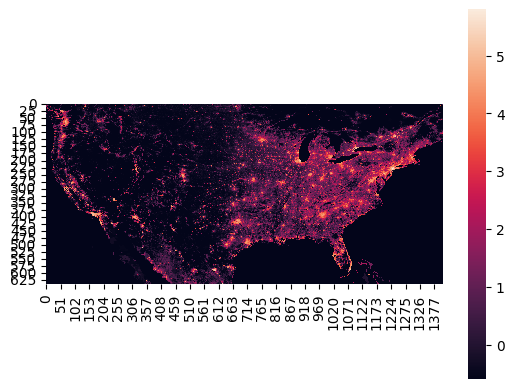

In [138]:
print(min(new_popd_grid.flatten()))
unnormalized_popd_grid = 10 ** (new_popd_grid - min(new_popd_grid.flatten())) - 1
print(min(unnormalized_popd_grid.flatten()), max(unnormalized_popd_grid.flatten()))
sns.heatmap(new_popd_grid[0], square=True)

## Some math!

To calculate the total energy consumption of an area given the yearly average, minimum, and maximum temperatures along with the population density, median incomes, and AC access by household income level. This number is not exact due to the very human element of air conditioning usage. We model the temperature throughout the year as an approximately sinusoidal as typically observed (https://en.climate-data.org/north-america/united-states-of-america/new-york/new-york-1091/) with the minimum and maximum temperatures, $T_{min}$ and $T_{max}$, respectively, representing the minimum and maxiumum values of the function. 
$$\begin{align}
    T(M) = (\frac{T_{max} - T_{min}}{2})\cos(\frac{M\pi}{6} + \pi) + \frac{T_{max} + T_{min}}{2}
\end{align}$$


We also assume a period of one year for temperature variance. We use the standard temperature $18.3^{\circ}C$ to compute the degree days from.

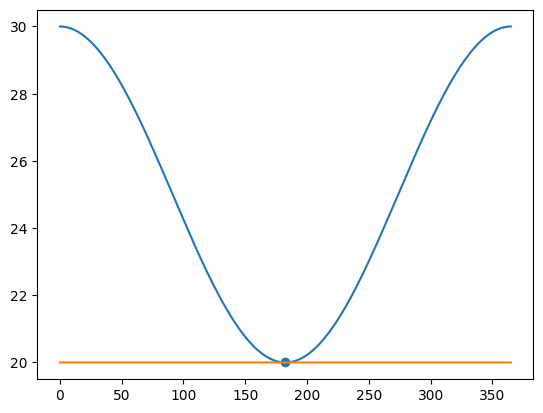

In [116]:
def sinusoid(T_min, T_max, x):
    return (T_max - T_min) / 2. * np.cos(2. * np.pi * x / 365) + (T_max + T_min) / 2.

def dstar(T_min, T_max, T_ac):
    return (365. / (np.pi * 2.)) * np.arccos((T_ac - ((T_max + T_min) / 2.)) * (2. / (T_max - T_min)))

t1 = 20
t2 = 30
t3 = 20
x = np.arange(0, 365, 0.1)
t_std = t3
plt.plot(x, sinusoid(t1, t2, x))
plt.plot(x, [t_std] * len(x))
plt.scatter([dstar(t1, t2, t3)], [t_std])

<Axes: >

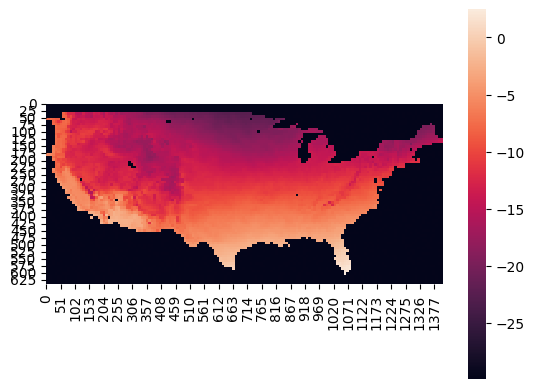

In [120]:
sns.heatmap(new_tmin_grid[0], square=True)

<Axes: >

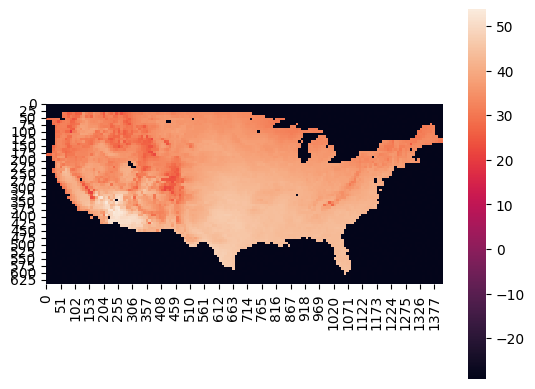

In [121]:
sns.heatmap(new_tmax_grid[0], square=True)

In [126]:
T_ac = 18.3

def calculate_degree_days(T_min, T_max, T_ac):
    if T_min >= T_max or T_max < T_ac:
        return 0
    d_star = (365. / (np.pi * 2.)) * np.arccos((T_ac - ((T_max + T_min) / 2.)) * (2. / (T_max - T_min)))
    degree_days_tot = ((365. / (2. * np.pi) * ((T_max - T_min) / 2.) * np.sin((2. * np.pi * d_star) / 365.)) + ((T_max + T_min) / 2. - T_ac) * d_star) * 2.
    return degree_days_tot

def temp_to_degree_day_grid(tmin_grid, tmax_grid, T_ac):
    degree_day_data = []
    for t in range(len(tmin_grid)):
        year_data = []
        for y in range(len(tmin_grid[0])):
            row_data = []
            for x in range(len(tmax_grid[0][0])):
                row_data.append(calculate_degree_days(tmin_grid[t,y,x], tmax_grid[t,y,x], T_ac))
            year_data.append(row_data)
        degree_day_data.append(year_data)
    return np.array(degree_day_data)

degree_day_grid = temp_to_degree_day_grid(new_tmin_grid, new_tmax_grid, T_ac)

In [131]:
min_degree_days = min([x for x in degree_day_grid.flatten() if x > 0])
max_degree_days = max([x for x in degree_day_grid.flatten() if x > 0])
print(min_degree_days, max_degree_days)

18.317956514292632 4837.020591719161


<Axes: >

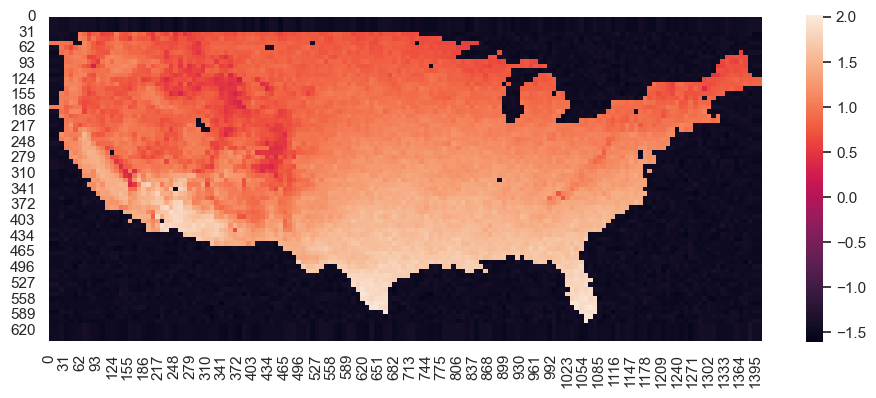

In [194]:
sns.heatmap(new_tavg_grid[-1] - new_tavg_grid[0], square=True)

<Axes: >

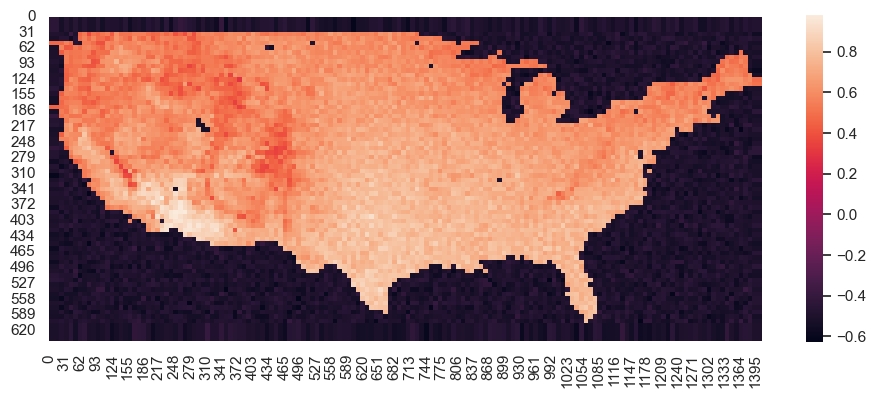

In [195]:
sns.heatmap(new_tmax_grid[-1] - new_tmax_grid[0], square=True)

<Axes: >

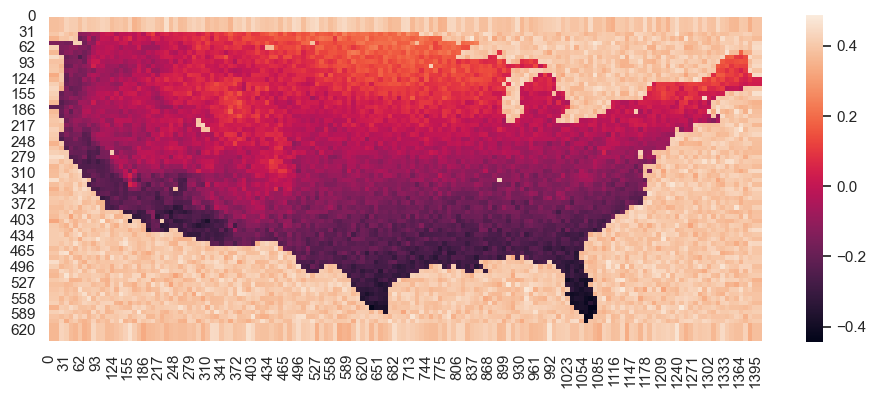

In [196]:
sns.heatmap(new_tmin_grid[-1] - new_tmin_grid[0], square=True)

In [151]:
# normalize population density to 2020 density
# https://www.census.gov/popclock/
pop_d_norm_factor = sum(unnormalized_popd_grid[0].flatten()) / 329000000
normalized_popd_grid = unnormalized_popd_grid / pop_d_norm_factor
for t in range(len(unnormalized_popd_grid)):
    print(min(normalized_popd_grid[t].flatten()))
    print("Estimated 20" + str(20 + t * 5) + " population: " + str(sum(normalized_popd_grid[t].flatten()).round(6)))

0.0
Estimated 2020 population: 329000000.00001
0.0
Estimated 2025 population: 320093946.264886
0.0
Estimated 2030 population: 312029959.339439


In [160]:
# format datasets to match years
print(degree_day_grid.shape)
print(normalized_popd_grid.shape)
print(np.array(median_income_grid).shape)
degree_day_final_grid   = np.array([degree_day_grid[0], degree_day_grid[5], degree_day_grid[-1]])
pop_d_final_grid        = np.array(normalized_popd_grid)
income_final_grid       = np.array([median_income_grid[0], median_income_grid[5], median_income_grid[-1]])
print(degree_day_final_grid.shape)
print(pop_d_final_grid.shape)
print(income_final_grid.shape)

(10, 640, 1408)
(3, 640, 1408)
(11, 640, 1408)
(3, 640, 1408)
(3, 640, 1408)
(3, 640, 1408)


In [252]:
def find_ac_prop(median_income, access_fits, year):
    idx = 4
    for i in range(4):
        if median_income < 80000 - 20000 * i:
            idx -= 1
    return access_fits[i][0] * year + access_fits[i][1]


def compute_yearly_energy_consumption(degree_day_grid, popd_grid, income_grid, access_fits):
    # 2.57 people per household
    heads_per_household = 2.57
    final_energy_grid = []
    for t in range(3):
        year_data = []
        for y in range(len(degree_day_grid[0])):
            row_data = []
            for x in range(len(degree_day_grid[0][0])):
                EC = degree_day_grid[t,y,x] * popd_grid[t,y,x] * find_ac_prop(income_grid[t,y,x], access_fits, 2020 + t * 5) / heads_per_household
                row_data.append(max(0, EC))
            year_data.append(row_data)
        final_energy_grid.append(year_data)
            
    return np.array(final_energy_grid) 

In [253]:
energy_grid_final = compute_yearly_energy_consumption(degree_day_final_grid, pop_d_final_grid, income_final_grid, access_fits)

In [254]:
print(energy_grid_final.shape)

(3, 640, 1408)


In [255]:
baseline_energy_consumption = 409000000000 * 0.6 # total US residential energy consumption in kWh
energy_scale_factor = baseline_energy_consumption / sum(energy_grid_final[0].flatten())
print(energy_scale_factor)
energy_max_density = np.log(np.max(energy_grid_final.flatten()))

for i in range(3):
    print("Estimated " + str(2020 + i * 5) + " energy consumption (TWh): " + str(sum((energy_grid_final[i].flatten()) * energy_scale_factor / 1e9).round(1)))

    # plot the heatmap
    ax = sns.heatmap(np.log(energy_grid_final[i] + 1), square=True, vmax=energy_max_density)
    year = 2020 + i * 5
    ax.set_title("Projected Energy Consumption: " + str(year))
    ax.set(xticklabels=[], yticklabels=[])
    ax.tick_params(bottom=False, left=False)
    fig = ax.get_figure()
    file_name = "./final_figures/Energy_Consumption/EnergyConsumption" + str(year) + ".png"
    fig.savefig(file_name, dpi=200, bbox_inches='tight')
    fig.clear()
    ax.clear()

1.188544975004513
Estimated 2020 energy consumption (TWh): 245.4
Estimated 2025 energy consumption (TWh): 262.2
Estimated 2030 energy consumption (TWh): 279.4


<Figure size 1150x425 with 0 Axes>

0.2448411193840947


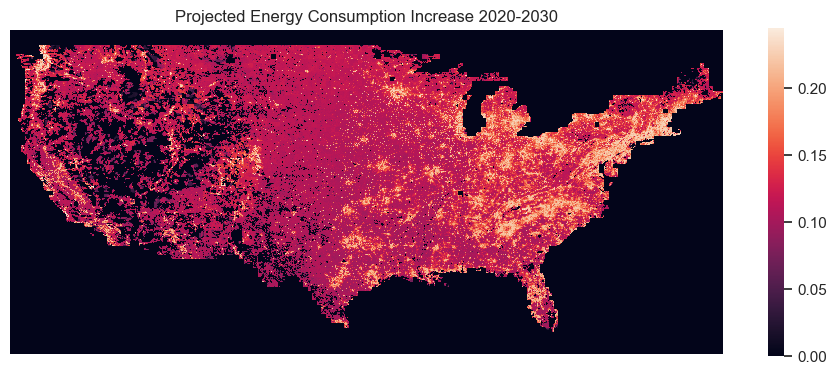

In [256]:
# plot energy use increases
vmax_percentile_arr = sorted((np.log(energy_grid_final[2] + 1) - np.log(energy_grid_final[0] + 1)).flatten())
percentile = 0.9999
vmax = vmax_percentile_arr[int(len(vmax_percentile_arr) * percentile)]
print(vmax)
ax = sns.heatmap(np.log(energy_grid_final[2] + 1) - np.log(energy_grid_final[0] + 1), square=True, vmin=0, vmax = vmax)
ax.set_title("Projected Energy Consumption Increase 2020-2030")
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
fig = ax.get_figure()
file_name = "./final_figures/Energy_Consumption/EnergyConsumptionIncrease.png"
fig.savefig(file_name, dpi=200, bbox_inches='tight')

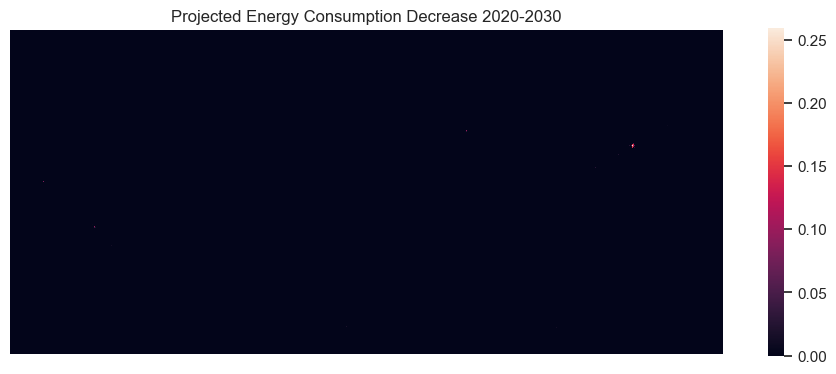

In [257]:
# plot energy use decreases
ax = sns.heatmap(-1. * (np.log(energy_grid_final[2] + 1) - np.log(energy_grid_final[0] + 1)), square=True, vmin = 0)
ax.set_title("Projected Energy Consumption Decrease 2020-2030")
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
fig = ax.get_figure()
file_name = "./final_figures/Energy_Consumption/EnergyConsumptionDecrease.png"
fig.savefig(file_name, dpi=200, bbox_inches='tight')

1.188544975004513
Estimated 2020 energy consumption (TWh): 245.4
Estimated 2025 energy consumption (TWh): 262.2
Estimated 2030 energy consumption (TWh): 279.4


<Axes: >

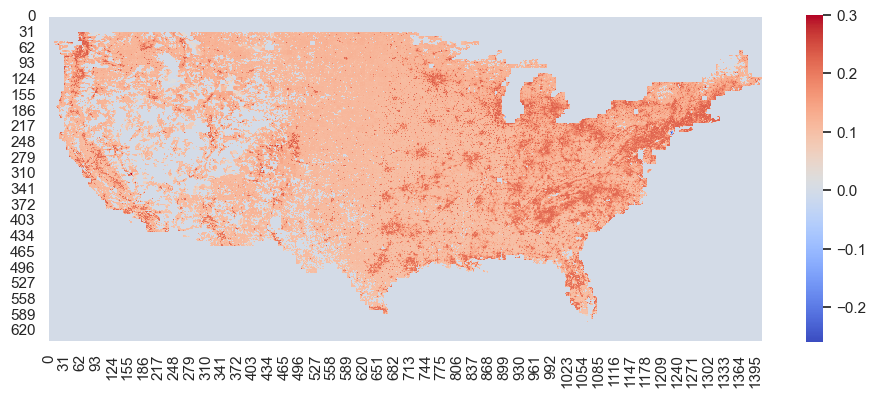

In [258]:
degree_day_final_grid   = np.array([degree_day_grid[0], degree_day_grid[5], degree_day_grid[-1]])
pop_d_final_grid        = np.array(normalized_popd_grid)
income_final_grid       = np.array([median_income_grid[0], median_income_grid[5], median_income_grid[-1]])
# https://www.census.gov/data/tables/2023/demo/popproj/2023-summary-tables.html
census_projected_pop    = [329000000, 338016000, 345074000]
adjusted_pop_d_grid     = pop_d_final_grid
for i in range(3):
    adjusted_pop_d_grid[i] = adjusted_pop_d_grid[i] / sum(adjusted_pop_d_grid[i].flatten()) * census_projected_pop[i]

adjusted_energy_grid_final = compute_yearly_energy_consumption(degree_day_final_grid, adjusted_pop_d_grid, income_final_grid, access_fits)

baseline_energy_consumption = 409000000000 * 0.6 # total US residential energy consumption in kWh
energy_scale_factor = baseline_energy_consumption / sum(adjusted_energy_grid_final[0].flatten())
print(energy_scale_factor)

for i in range(3):
    print("Estimated " + str(2020 + i * 5) + " energy consumption (TWh): " + str(sum((adjusted_energy_grid_final[i].flatten()) * energy_scale_factor / 1e9).round(1)))
sns.heatmap(np.log(adjusted_energy_grid_final[2] + 1) - np.log(adjusted_energy_grid_final[0] + 1), square=True, cmap='coolwarm', vmax=0.3)

0.28135134902976766


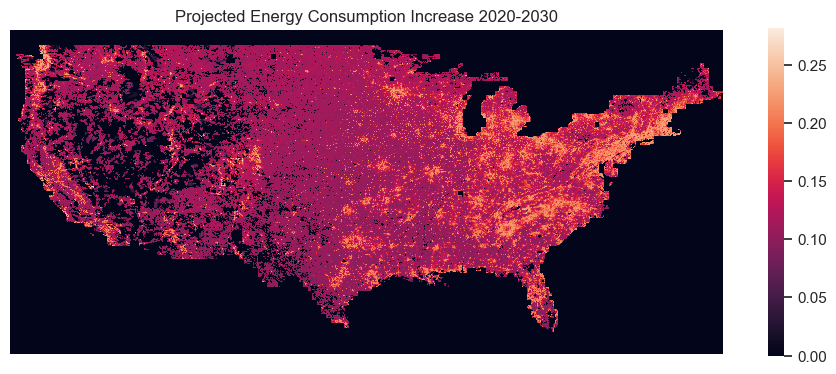

In [259]:
# plot energy use increases
vmax_percentile_arr = sorted((np.log(adjusted_energy_grid_final[2] + 1) - np.log(adjusted_energy_grid_final[0] + 1)).flatten())
percentile = 0.999975
vmax = vmax_percentile_arr[int(len(vmax_percentile_arr) * percentile)]
print(vmax)
ax = sns.heatmap(np.log(adjusted_energy_grid_final[2] + 1) - np.log(adjusted_energy_grid_final[0] + 1), square=True, vmin=0, vmax = vmax)
ax.set_title("Projected Energy Consumption Increase 2020-2030")
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
fig = ax.get_figure()
file_name = "./final_figures/Energy_Consumption/EnergyConsumptionIncreasePopulationAdjusted.png"
fig.savefig(file_name, dpi=200, bbox_inches='tight')

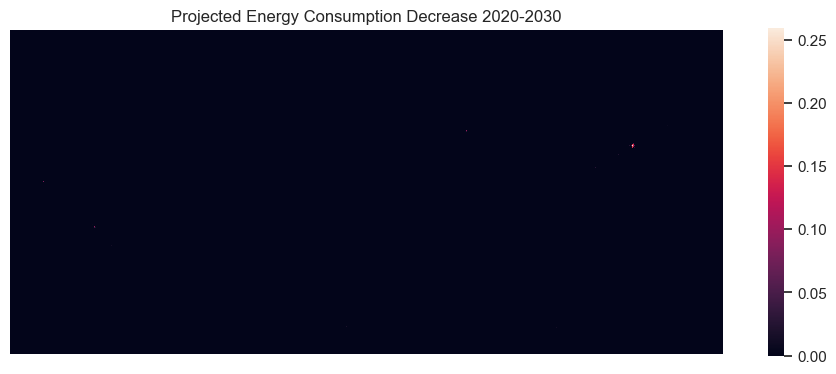

In [260]:
# plot energy use decreases
ax = sns.heatmap(-1. * (np.log(adjusted_energy_grid_final[2] + 1) - np.log(adjusted_energy_grid_final[0] + 1)), square=True, vmin = 0)
ax.set_title("Projected Energy Consumption Decrease 2020-2030")
ax.set(xticklabels=[], yticklabels=[])
ax.tick_params(bottom=False, left=False)
fig = ax.get_figure()
file_name = "./final_figures/Energy_Consumption/EnergyConsumptionDecreasePopulationAdjusted.png"
fig.savefig(file_name, dpi=200, bbox_inches='tight')